In [68]:
import gc
import numpy as np
import pandas as pd
import yfinance as yf
import back_testing as bt
import matplotlib.pyplot as plt

gc.collect()

84

In [69]:
weight_df = pd.read_csv('data/weight_df.csv', index_col=0)
tic_df = pd.read_csv('data/tic_df.csv', index_col=0)
returns_df = pd.read_csv('data/returns_df.csv', index_col=0).loc[weight_df.index]
returns_df.index = pd.to_datetime(returns_df.index)
weight_df.index = pd.to_datetime(weight_df.index)
equal_weight_df = pd.DataFrame(1 / len(weight_df.columns), index=weight_df.index, columns=weight_df.columns)

weight_dict={}
weight_dict['Equal'] = equal_weight_df
weight_dict['Dynamic'] = weight_df

[*********************100%***********************]  1 of 1 completed

설정:
  - 기본 수수료: 0bp
  - Turnover 배수: 1
  - 리밸런싱 주기: A


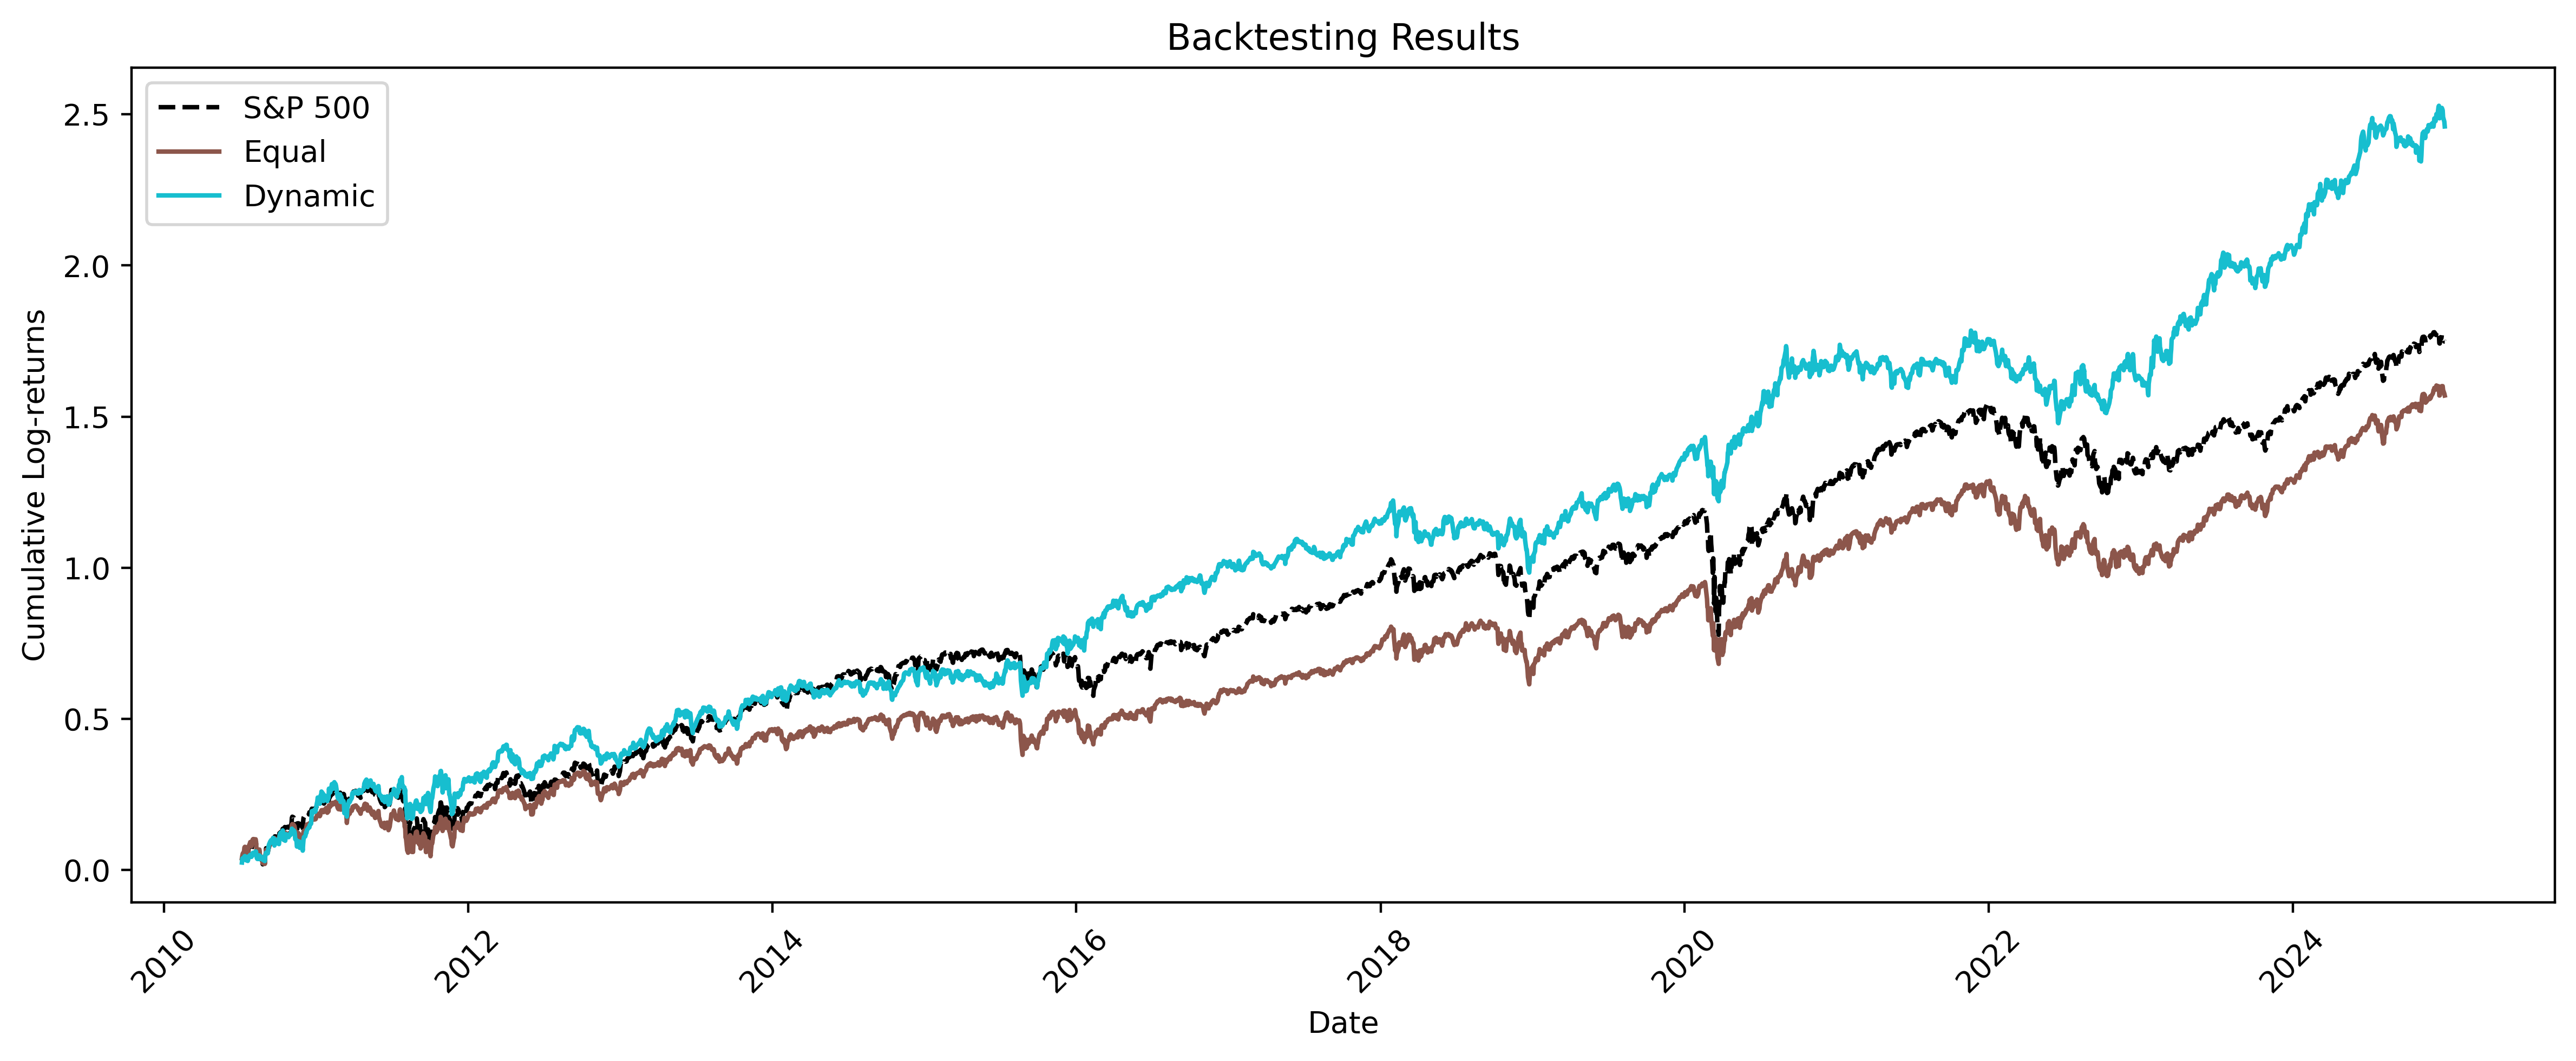

In [70]:
# 백테스팅 설정
base_fee = 0.00  # 기본 수수료 0.2%
turnover_multiplier = 1  # turnover에 따른 수수료 증가 배수
rebalance_freq = 'A' # 적응형 리벨런싱 주기

print(f"설정:")
print(f"  - 기본 수수료: {base_fee*10000:.0f}bp")
print(f"  - Turnover 배수: {turnover_multiplier}")
print(f"  - 리밸런싱 주기: {rebalance_freq}")

# 백테스팅 실행
result_df = pd.DataFrame()
for str_name in weight_dict.keys():

    result_df = bt.return_Table(
        weight_dict[str_name], 
        returns_df,  # 가격 데이터 직접 전달
        result_df,
        rebalance_freq=rebalance_freq,
        fee=base_fee,
        turnover_multiplier=turnover_multiplier,
        tic_df=tic_df
    )
    
# 컬럼명 설정 (S&P 500 + 전략들)
result_df.columns = ['S&P 500'] + list(weight_dict.keys())

bt.plot_result(result_df)

In [71]:
out = bt.compute_turnover_and_fee(base_fee, turnover_multiplier, weight_dict['Equal'], 'A', tic_df)
print(f"Equal: {out['turnover'].mean():.4f}")
print(f"Equal: {out['fee_log'].sum():.4f}")

out = bt.compute_turnover_and_fee(base_fee, turnover_multiplier, weight_dict['Dynamic'], 'A', tic_df)
print(f"Dynamic: {out['turnover'].mean():.4f}")
print(f"Dynamic: {out['fee_log'].sum():.4f}")

Equal: 0.0022
Equal: 0.0000
Dynamic: 0.0414
Dynamic: 0.0000


In [72]:
metric = bt.METRICS(result_df.dropna())
metric.cal_describe()
metric.cal_monthly_statistics()

In [73]:
metric.annual_statistics

,S&P 500,Equal,Dynamic
Date,2010-07-07 ~ 2024-12-31,2010-07-07 ~ 2024-12-31,2010-07-07 ~ 2024-12-31
count,3647,3647,3647
cumulative return,474.57148,375.97916,1064.85057
annualized return mean,0.12842,0.11383,0.18489
annualized return std,0.18733,0.17011,0.20467
annualized return downside std,0.15367,0.12857,0.1459
sharpe ratio,0.68551,0.66916,0.90334
sortino ratio,0.83564,0.88539,1.26719
gross profit,13.91815,13.57571,16.78208
gross loss,-12.1697,-12.0155,-14.3269


In [74]:
metric.monthly_statistics

,S&P 500,Equal,Dynamic
Mean,0.00048,0.00043,0.00067
Standard deviation,0.01082,0.0099,0.01173
Standard error,0.00018,0.00016,0.00019
t-statistic,2.9139,2.8305,3.7167
Min,-0.12765,-0.04756,-0.04779
25%,-0.00376,-0.00399,-0.0052
50%,0.00067,0.00067,0.00088
75%,0.00568,0.0057,0.00691
Max,0.08968,0.04558,0.04937
Skew,-0.75011,-0.37558,-0.26233


In [75]:
metric.save_results('./general_results')